# Overview

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# from pmdarima.arima import auto_arima
from gensim.models import KeyedVectors
import tensorflow as tf
import spacy
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram
from pylab import rcParams
import re
from datetime import date

rcParams['figure.figsize'] = 10, 5
pd.options.mode.chained_assignment = None
%matplotlib inline

In [3]:
items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
item_categories = pd.read_csv("./data/item_categories.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")

In [4]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [8]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [9]:
# Check missing values
print("items:\n" + str(items.isna().sum()) + "\n")
print("train:\n" + str(train.isna().sum()) + "\n")
print("test:\n" + str(test.isna().sum()) + "\n")

items:
item_name           0
item_id             0
item_category_id    0
dtype: int64

train:
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

test:
ID         0
shop_id    0
item_id    0
dtype: int64



# Preprocessing

## train

In [10]:
print(f"The number of shops: {train['shop_id'].unique().shape[0]}")
print(f"The number of items: {train['item_id'].unique().shape[0]}")

The number of shops: 60
The number of items: 21807


### Format: date

In [11]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

### Anomalies in item_price column

In [12]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [13]:
train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
453034,2013-05-15,4,25,2973,1249.5,1.0
469026,2013-05-15,4,46,2973,1249.5,1.0
469951,2013-05-15,4,45,2973,1249.0,1.0
484683,2013-05-15,4,32,2973,-1.0,1.0


In [14]:
missing_price = train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973) & (train['item_price'] > 0)]
train.loc[train['item_price'] < 0, "item_price"] = missing_price['item_price'].mean()

In [15]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


### Anomalies in item_cnt_day column

In [16]:
negative_train = train[train['item_cnt_day'] < 0]

In [17]:
# Statistics: item_price
train['item_price'].describe()

count    2.935849e+06
mean     8.908537e+02
std      1.729800e+03
min      7.000000e-02
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [18]:
# Statistics: item_price of records with item_cnt_day < 0
negative_train['item_price'].describe()

count     7356.000000
mean      1442.945623
std       2419.680132
min          0.500000
25%        349.000000
50%        799.000000
75%       1699.000000
max      33490.000000
Name: item_price, dtype: float64

In [19]:
train['item_cnt_day'] = np.where(train['item_cnt_day'] < 0, 0, train['item_cnt_day'])

### Date aggregation

In [20]:
train_g = train.groupby(by=['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('item_cnt_month').reset_index()
train_g

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609119,33,59,22087,6.0
1609120,33,59,22088,2.0
1609121,33,59,22091,1.0
1609122,33,59,22100,1.0


In [21]:
# from itertools import product

# zeros = []
# for i in range(34):
#     sales = train_g[train_g['date_block_num']==i]
#     zeros.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
# zeros = pd.DataFrame(np.vstack(zeros), columns=['date_block_num','shop_id','item_id'])

# train_g = train_g.merge(zeros, on=['date_block_num','shop_id','item_id'], how="right")
# train_g = train_g.fillna(0)
# train_g.isna().sum()

## test

In [22]:
print(f"The number of shops in train data: {train['shop_id'].unique().shape[0]}")
print(f"The number of shops in test data: {test['shop_id'].unique().shape[0]}")

The number of shops in train data: 60
The number of shops in test data: 42


In [23]:
print("Items appear in test set but not in train set:")
len(set(test["item_id"].unique().tolist()) - set(train["item_id"].unique().tolist()))

Items appear in test set but not in train set:


363

# Feature Engineering

## Text Embeddings

In [24]:
ru_model = KeyedVectors.load_word2vec_format('./wiki.ru.vec')

In [25]:
def extract_feature(text_col):
    features = list()
    len_lst = list()
    nlp = spacy.load("ru_core_news_lg")
    fail_count = 0
    
    for i in tqdm(range(text_col.shape[0])):
        one_feature = list()
        tokens = nlp (text_col[i])
        for token in tokens:
            try:
                one_feature.append(ru_model.get_vector(token.text))
            except:
                continue
        if len(one_feature) > 0:
            one_feature = np.stack(one_feature).flatten()
        else:
            one_feature = np.zeros(300)
            fail_count += 1
        features.append(one_feature)
        len_lst.append(one_feature.shape[0])
        
    med = int(pd.Series(len_lst).max())
    print(f"Max: {med}")
    feature_tp = list()
    for item in features:
        if item.shape[0] < med:
            item = np.concatenate([item, np.zeros(med - item.shape[0])])
        else:
            item = item[:med]
        feature_tp.append(item)
    
    print(f"Failed: {fail_count}")
    features = np.stack(feature_tp)
    return features

In [26]:
def encoding_cate(ser, num):
    ser_df = ser.value_counts().to_frame('count').reset_index()
    ser_df = ser_df.loc[ser_df['count'] > num, 'index']
    print(f"The number of classes: {ser_df.shape[0] + 1}")
    ser_df = pd.DataFrame({"cate": ser_df.tolist(), "index": list(range(ser_df.shape[0], 0, -1))})
    return ser.to_frame('cate').merge(ser_df, on='cate', how='left').fillna(0)['index'].astype(int)

### item_categories

In [27]:
item_categories_feature = extract_feature(item_categories['item_category_name'])

100%|██████████| 84/84 [00:00<00:00, 318.92it/s]

Max: 1800
Failed: 1


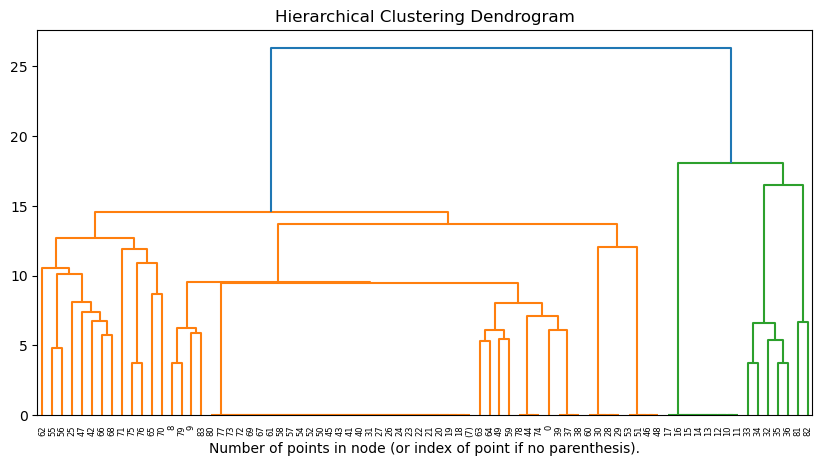

In [28]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)


clustering = AgglomerativeClustering(distance_threshold=8, n_clusters=None).fit(item_categories_feature)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(clustering, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [29]:
print(f"The number of classes: {np.unique(clustering.labels_).shape[0]}")
print(f"Check the shape of labels: {clustering.labels_.shape[0]}")
print(f"Labels: {clustering.labels_}")

The number of classes: 17
Check the shape of labels: 84
Labels: [ 2  6  6  6  6  6  6  6  5  5 11 11 11 11 11 11 11 11  6  6  6  6  6  6
  6 15  6  6 16 16 16  6  3  3  3  3  3  2  2  2  6  6  0  6  2  6  9  0
  9  7  6  9  6  9  6 12 12  6  6  7 16  6 10  7  7 14  0  6  0  6 13  8
  6  6  2  4  4  6  2  5  6  1  1  5]


In [30]:
item_categories['item_category_te'] = clustering.labels_
item_categories = item_categories.drop(columns=['item_category_name'])
item_categories

,item_category_id,item_category_te
0,0,2
1,1,6
2,2,6
3,3,6
4,4,6
...,...,...
79,79,5
80,80,6
81,81,1
82,82,1


In [31]:
cols = ["category_1", "category_2"]
item_categories_tfidf = pd.read_csv("./sales/_item_categories.csv", 
                                    usecols=["item_category_id", "category_1", "category_2"])

for col in cols:
    value_map = dict((v,i) for i,v in enumerate(item_categories_tfidf[col].unique()))
    item_categories_tfidf = item_categories_tfidf.replace({col:value_map})

item_categories_tfidf.head()

,item_category_id,category_1,category_2
0,0,0,0
1,1,1,1
2,2,1,2
3,3,1,3
4,4,1,4


### shops

In [32]:
shops_feature = extract_feature(shops['shop_name'])

100%|██████████| 60/60 [00:00<00:00, 312.96it/s]

Max: 1500
Failed: 2


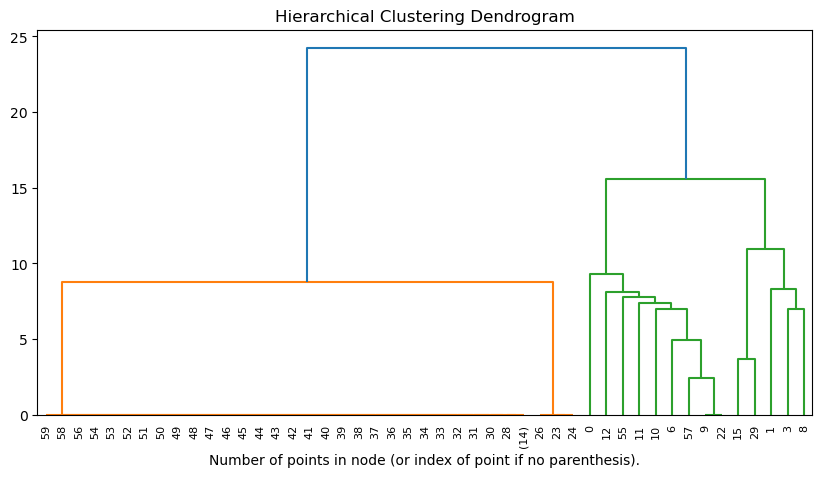

In [33]:
clustering = AgglomerativeClustering(distance_threshold=8, n_clusters=None).fit(shops_feature)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(clustering, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [34]:
print(f"The number of classes: {np.unique(clustering.labels_).shape[0]}")
print(f"Check the shape of labels: {clustering.labels_.shape[0]}")
print(f"Labels: {clustering.labels_}")

The number of classes: 8
Check the shape of labels: 60
Labels: [4 6 5 1 5 5 0 5 1 0 0 0 7 5 5 3 5 5 5 5 5 5 0 2 2 5 2 5 5 3 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 5 0 5 5]


In [35]:
shop_name = shops['shop_name'].str.split(pat=' ', n=2)
def remove_stopping_words(lst):
    new_lst = list()
    for i in lst:
        i = i.strip(',?!"()')
        i = re.sub('"', '', i)
        i = re.sub('\(', '', i)
        if i != "":
            new_lst.append(i)
    return new_lst

shop_name_split = shop_name.apply(remove_stopping_words)
shop_city = shop_name_split.apply(lambda x: x[0])
shop_info = shop_name_split.apply(lambda x: x[1])

In [36]:
shops['city'] = encoding_cate(shop_city, 0)
shops['info'] = encoding_cate(shop_info, 1)
shops['shop_te'] = clustering.labels_
shops = shops.drop(columns=['shop_name'])
shops.head()

The number of classes: 32
The number of classes: 7


,shop_id,city,info,shop_te
0,0,30,2,4
1,1,30,6,6
2,2,10,6,5
3,3,2,4,1
4,4,3,6,5


In [37]:
cols = ["shop_kind", "city", "shop_brand"]
shops_tfidf = pd.read_csv("./sales/_shops.csv", usecols=["shop_id", "shop_kind", "city", "shop_brand"])

for col in cols:
    value_map = dict((v,i) for i,v in enumerate(shops_tfidf[col].unique()))
    shops_tfidf = shops_tfidf.replace({col:value_map})

shops_tfidf = shops_tfidf.rename(columns={'city': 'city2'})
shops_tfidf.head()

,shop_id,city2,shop_kind,shop_brand
0,0,0,0,0
1,1,0,1,1
2,2,1,1,2
3,3,2,2,3
4,4,3,1,4


### items

In [38]:
# The first word in item name
first_word = items['item_name'].str.split(pat=' ').apply(lambda x: x[0])
first_word = encoding_cate(first_word, 3)

The number of classes: 1224


In [39]:
# Information about the item in ()
def trans_lst(col):
    if len(col) > 0:
        item = col[0]
        item = item.lower()
        item = re.sub("\s", "", item)
        item = item.strip("\[\s\t\n")
    else:
        item = ""
    return item

item_addons = items['item_name'].str.findall(r'\((.+?)\)').apply(trans_lst)
item_addons = encoding_cate(item_addons, 35)

The number of classes: 27


In [40]:
# Information about the item in []
item_addons_2 = items['item_name'].str.findall(r'\[(.+?)[,\]...]').apply(trans_lst)
item_addons_2 = encoding_cate(item_addons_2, 10)

The number of classes: 14


In [41]:
items['first_word'] = first_word
items['item_addons'] = item_addons
items['item_addons_2'] = item_addons_2
items = items.drop(columns=['item_name'])
items

,item_id,item_category_id,first_word,item_addons,item_addons_2
0,0,40,0,0,13
1,1,76,0,26,12
2,2,40,0,0,13
3,3,40,0,0,13
4,4,40,0,0,13
...,...,...,...,...,...
22165,22165,31,0,26,12
22166,22166,54,0,26,9
22167,22167,49,0,0,13
22168,22168,62,0,26,13


In [42]:
items_tfidf = pd.read_csv("./sales/items.csv")
feature_count = 25
tfidf = TfidfVectorizer(max_features=feature_count)
items_df_item_name_text_features = tfidf.fit_transform(items_tfidf['item_name']).toarray().tolist()
items_tfidf["item_names_tf_idf"] = items_df_item_name_text_features
items_tfidf.drop('item_name', axis = 1, inplace = True)
items_tfidf

,item_id,item_category_id,item_names_tf_idf
0,0,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,76,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.63789760..."
2,2,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
22165,22165,31,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22166,22166,54,"[0.6725131066380127, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22167,22167,49,"[0.6991949949697428, 0.0, 0.0, 0.0, 0.71493101..."
22168,22168,62,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Structural Embeddings

### Date

In [43]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['quarter'] = train['date'].dt.quarter
train['daysinmonth'] = train['date'].dt.daysinmonth
train['is_busday'] = np.is_busday(train['date'].dt.date.tolist()).astype(int)
train_busdays = train.loc[:, ['date', 'date_block_num', 'is_busday']].drop_duplicates()
train = train.merge(train_busdays.groupby(by=['date_block_num'])['is_busday'].sum().to_frame('n_busdays'),
                    on='date_block_num',
                    how='left')
train = train.drop(columns=['is_busday'])
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,quarter,daysinmonth,n_busdays
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,1,31,23
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,1,31,23
2,2013-01-05,0,25,2552,899.00,0.0,2013,1,1,31,23
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,1,31,23
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,1,31,23
...,...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,2015,10,4,31,22
2935845,2015-10-09,33,25,7460,299.00,1.0,2015,10,4,31,22
2935846,2015-10-14,33,25,7459,349.00,1.0,2015,10,4,31,22
2935847,2015-10-22,33,25,7440,299.00,1.0,2015,10,4,31,22


In [44]:
train_date = train.loc[:, ['date_block_num', 'shop_id', 'item_id', 'year', 'month', 
                           'quarter', 'daysinmonth', 'n_busdays']]
train_date = train_date.groupby(by=['date_block_num', 'shop_id', 'item_id']).median().astype(int).reset_index()
train_g = train_g.merge(train_date, on=['date_block_num', 'shop_id', 'item_id'], how='left')
train_g

,date_block_num,shop_id,item_id,item_cnt_month,year,month,quarter,daysinmonth,n_busdays
0,0,0,32,6.0,2013,1,1,31,23
1,0,0,33,3.0,2013,1,1,31,23
2,0,0,35,1.0,2013,1,1,31,23
3,0,0,43,1.0,2013,1,1,31,23
4,0,0,51,2.0,2013,1,1,31,23
...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,2015,10,4,31,22
1609120,33,59,22088,2.0,2015,10,4,31,22
1609121,33,59,22091,1.0,2015,10,4,31,22
1609122,33,59,22100,1.0,2015,10,4,31,22


In [45]:
train_g.isna().sum()

date_block_num    0
shop_id           0
item_id           0
item_cnt_month    0
year              0
month             0
quarter           0
daysinmonth       0
n_busdays         0
dtype: int64

In [46]:
test['date_block_num'] = 34
test['year'] = 2015
test['month'] = 11
test['quarter'] = 4
test['daysinmonth'] = 30
test['n_busdays'] = np.busday_count('2015-11', '2015-12')
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays
0,0,5,5037,34,2015,11,4,30,21
1,1,5,5320,34,2015,11,4,30,21
2,2,5,5233,34,2015,11,4,30,21
3,3,5,5232,34,2015,11,4,30,21
4,4,5,5268,34,2015,11,4,30,21
...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21
214196,214196,45,16188,34,2015,11,4,30,21
214197,214197,45,15757,34,2015,11,4,30,21
214198,214198,45,19648,34,2015,11,4,30,21


### Price

In [47]:
# Price Median
price_med = train.loc[:, ['item_id', 'item_price']].groupby(by=['item_id']).median().reset_index()
price_med = price_med.rename(columns={'item_price': 'item_price_med'})
train = train_g.merge(price_med, on='item_id', how='left')
test = test.merge(price_med, on='item_id', how='left')

In [48]:
train

,date_block_num,shop_id,item_id,item_cnt_month,year,month,quarter,daysinmonth,n_busdays,item_price_med
0,0,0,32,6.0,2013,1,1,31,23,221.0
1,0,0,33,3.0,2013,1,1,31,23,199.0
2,0,0,35,1.0,2013,1,1,31,23,399.0
3,0,0,43,1.0,2013,1,1,31,23,198.0
4,0,0,51,2.0,2013,1,1,31,23,249.0
...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,2015,10,4,31,22,79.0
1609120,33,59,22088,2.0,2015,10,4,31,22,79.0
1609121,33,59,22091,1.0,2015,10,4,31,22,109.0
1609122,33,59,22100,1.0,2015,10,4,31,22,629.0


In [49]:
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,item_price_med
0,0,5,5037,34,2015,11,4,30,21,1999.0
1,1,5,5320,34,2015,11,4,30,21,NaN
2,2,5,5233,34,2015,11,4,30,21,599.5
3,3,5,5232,34,2015,11,4,30,21,599.5
4,4,5,5268,34,2015,11,4,30,21,NaN
...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,199.0
214196,214196,45,16188,34,2015,11,4,30,21,1223.0
214197,214197,45,15757,34,2015,11,4,30,21,199.0
214198,214198,45,19648,34,2015,11,4,30,21,99.0


### Release Date

In [50]:
release = pd.concat([train_g.loc[:, ['date_block_num', 'item_id']],
                    test.loc[:, ['date_block_num', 'item_id']]])
release = release.groupby(by=['item_id']).min().reset_index()
release = release.rename(columns={'date_block_num': 'release_date'})
train = train.merge(release, on='item_id', how='left')
test = test.merge(release, on='item_id', how='left')

In [51]:
train

,date_block_num,shop_id,item_id,item_cnt_month,year,month,quarter,daysinmonth,n_busdays,item_price_med,release_date
0,0,0,32,6.0,2013,1,1,31,23,221.0,0
1,0,0,33,3.0,2013,1,1,31,23,199.0,0
2,0,0,35,1.0,2013,1,1,31,23,399.0,0
3,0,0,43,1.0,2013,1,1,31,23,198.0,0
4,0,0,51,2.0,2013,1,1,31,23,249.0,0
...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,2015,10,4,31,22,79.0,0
1609120,33,59,22088,2.0,2015,10,4,31,22,79.0,0
1609121,33,59,22091,1.0,2015,10,4,31,22,109.0,0
1609122,33,59,22100,1.0,2015,10,4,31,22,629.0,30


In [52]:
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,item_price_med,release_date
0,0,5,5037,34,2015,11,4,30,21,1999.0,20
1,1,5,5320,34,2015,11,4,30,21,NaN,34
2,2,5,5233,34,2015,11,4,30,21,599.5,27
3,3,5,5232,34,2015,11,4,30,21,599.5,31
4,4,5,5268,34,2015,11,4,30,21,NaN,34
...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,199.0,23
214196,214196,45,16188,34,2015,11,4,30,21,1223.0,32
214197,214197,45,15757,34,2015,11,4,30,21,199.0,0
214198,214198,45,19648,34,2015,11,4,30,21,99.0,23


In [53]:
train.to_csv("_train.csv")
test.to_csv("_test.csv")

In [54]:
train = pd.read_csv("_train.csv", index_col=0)
test = pd.read_csv("_test.csv", index_col=0)

### Sales Lag

In [55]:
def lag_features(df, group, on_cols, col, lags=[1,2,3,6,12]):
    # temp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        shifted = group.copy()
        shifted = shifted.rename(columns={col: col+'_lag_'+str(i)})
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=on_cols, how='left')
    return df

In [56]:
group = train.loc[:, ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']]
group = group.groupby(by=['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['month_avg_item_cnt']
group.reset_index(inplace = True)

train = train.merge(group, on=['date_block_num'], how='left')
train = lag_features(df=train, group=group, on_cols=['date_block_num'], col='month_avg_item_cnt', lags=[1])
train.drop(['month_avg_item_cnt'], axis=1, inplace=True)
train

,date_block_num,shop_id,item_id,item_cnt_month,year,month,quarter,daysinmonth,n_busdays,item_price_med,release_date,month_avg_item_cnt_lag_1
0,0,0,32,6.0,2013,1,1,31,23,221.0,0,NaN
1,0,0,33,3.0,2013,1,1,31,23,199.0,0,NaN
2,0,0,35,1.0,2013,1,1,31,23,399.0,0,NaN
3,0,0,43,1.0,2013,1,1,31,23,198.0,0,NaN
4,0,0,51,2.0,2013,1,1,31,23,249.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,2015,10,4,31,22,79.0,0,2.459364
1609120,33,59,22088,2.0,2015,10,4,31,22,79.0,0,2.459364
1609121,33,59,22091,1.0,2015,10,4,31,22,109.0,0,2.459364
1609122,33,59,22100,1.0,2015,10,4,31,22,629.0,30,2.459364


In [57]:
test = lag_features(df=test, group=group, on_cols=['date_block_num'], col='month_avg_item_cnt', lags=[1])
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,item_price_med,release_date,month_avg_item_cnt_lag_1
0,0,5,5037,34,2015,11,4,30,21,1999.0,20,2.257588
1,1,5,5320,34,2015,11,4,30,21,NaN,34,2.257588
2,2,5,5233,34,2015,11,4,30,21,599.5,27,2.257588
3,3,5,5232,34,2015,11,4,30,21,599.5,31,2.257588
4,4,5,5268,34,2015,11,4,30,21,NaN,34,2.257588
...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,199.0,23,2.257588
214196,214196,45,16188,34,2015,11,4,30,21,1223.0,32,2.257588
214197,214197,45,15757,34,2015,11,4,30,21,199.0,0,2.257588
214198,214198,45,19648,34,2015,11,4,30,21,99.0,23,2.257588


In [58]:
group = train.loc[:, ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']]
group = group.groupby(by=['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['month_item_avg_item_cnt']
group.reset_index(inplace = True)

train = lag_features(df=train, group=group, on_cols=['date_block_num', 'item_id'], col='month_item_avg_item_cnt', lags=[1,2,3,6,12])
train

,date_block_num,shop_id,item_id,item_cnt_month,year,month,quarter,daysinmonth,n_busdays,item_price_med,release_date,month_avg_item_cnt_lag_1,month_item_avg_item_cnt_lag_1,month_item_avg_item_cnt_lag_2,month_item_avg_item_cnt_lag_3,month_item_avg_item_cnt_lag_6,month_item_avg_item_cnt_lag_12
0,0,0,32,6.0,2013,1,1,31,23,221.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,33,3.0,2013,1,1,31,23,199.0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,35,1.0,2013,1,1,31,23,399.0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,43,1.0,2013,1,1,31,23,198.0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,51,2.0,2013,1,1,31,23,249.0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,2015,10,4,31,22,79.0,0,2.459364,2.440000,2.392857,3.000000,2.392857,4.368421
1609120,33,59,22088,2.0,2015,10,4,31,22,79.0,0,2.459364,3.823529,4.555556,4.548387,4.580645,7.421053
1609121,33,59,22091,1.0,2015,10,4,31,22,109.0,0,2.459364,2.047619,2.000000,2.307692,1.666667,2.083333
1609122,33,59,22100,1.0,2015,10,4,31,22,629.0,30,2.459364,3.032258,3.181818,1.571429,NaN,NaN


In [59]:
test = lag_features(df=test, group=group, on_cols=['date_block_num', 'item_id'], col='month_item_avg_item_cnt', lags=[1,2,3,6,12])
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,item_price_med,release_date,month_avg_item_cnt_lag_1,month_item_avg_item_cnt_lag_1,month_item_avg_item_cnt_lag_2,month_item_avg_item_cnt_lag_3,month_item_avg_item_cnt_lag_6,month_item_avg_item_cnt_lag_12
0,0,5,5037,34,2015,11,4,30,21,1999.0,20,2.257588,1.470588,3.827586,3.305556,2.485714,2.0625
1,1,5,5320,34,2015,11,4,30,21,NaN,34,2.257588,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,34,2015,11,4,30,21,599.5,27,2.257588,1.555556,2.666667,3.846154,2.535714,NaN
3,3,5,5232,34,2015,11,4,30,21,599.5,31,2.257588,1.526316,1.846154,2.096774,NaN,NaN
4,4,5,5268,34,2015,11,4,30,21,NaN,34,2.257588,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,199.0,23,2.257588,1.000000,1.000000,1.000000,1.300000,NaN
214196,214196,45,16188,34,2015,11,4,30,21,1223.0,32,2.257588,1.000000,1.000000,NaN,NaN,NaN
214197,214197,45,15757,34,2015,11,4,30,21,199.0,0,2.257588,1.000000,1.000000,1.000000,1.222222,1.1250
214198,214198,45,19648,34,2015,11,4,30,21,99.0,23,2.257588,1.000000,1.000000,1.166667,1.000000,NaN


In [60]:
# Merge
train = train.merge(items, on='item_id', how='left')
test = test.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')
test = test.merge(item_categories, on='item_category_id', how='left')
train = train.merge(item_categories_tfidf, on='item_category_id', how='left')
test = test.merge(item_categories_tfidf, on='item_category_id', how='left')
train = train.merge(shops, on='shop_id', how='left')
test = test.merge(shops, on='shop_id', how='left')
train = train.merge(shops_tfidf, on='shop_id', how='left')
test = test.merge(shops_tfidf, on='shop_id', how='left')
train = train.merge(items_tfidf, on=['item_id', 'item_category_id'], how='left')
test = test.merge(items_tfidf, on=['item_id', 'item_category_id'], how='left')

In [61]:
group = train.loc[:, ['date_block_num', 'item_category_id', 'item_cnt_month']]
group = group.groupby(by=['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['month_cat_avg_item_cnt']
group.reset_index(inplace = True)

train = lag_features(df=train, group=group, on_cols=['date_block_num', 'item_category_id'], col='month_cat_avg_item_cnt', lags=[1,6])
train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'year',
       'month', 'quarter', 'daysinmonth', 'n_busdays', 'item_price_med',
       'release_date', 'month_avg_item_cnt_lag_1',
       'month_item_avg_item_cnt_lag_1', 'month_item_avg_item_cnt_lag_2',
       'month_item_avg_item_cnt_lag_3', 'month_item_avg_item_cnt_lag_6',
       'month_item_avg_item_cnt_lag_12', 'item_category_id', 'first_word',
       'item_addons', 'item_addons_2', 'item_category_te', 'category_1',
       'category_2', 'city', 'info', 'shop_te', 'city2', 'shop_kind',
       'shop_brand', 'item_names_tf_idf', 'month_cat_avg_item_cnt_lag_1',
       'month_cat_avg_item_cnt_lag_6'],
      dtype='object')

In [62]:
test = lag_features(df=test, group=group, on_cols=['date_block_num', 'item_category_id'], col='month_cat_avg_item_cnt', lags=[1,6])
test.columns

Index(['ID', 'shop_id', 'item_id', 'date_block_num', 'year', 'month',
       'quarter', 'daysinmonth', 'n_busdays', 'item_price_med', 'release_date',
       'month_avg_item_cnt_lag_1', 'month_item_avg_item_cnt_lag_1',
       'month_item_avg_item_cnt_lag_2', 'month_item_avg_item_cnt_lag_3',
       'month_item_avg_item_cnt_lag_6', 'month_item_avg_item_cnt_lag_12',
       'item_category_id', 'first_word', 'item_addons', 'item_addons_2',
       'item_category_te', 'category_1', 'category_2', 'city', 'info',
       'shop_te', 'city2', 'shop_kind', 'shop_brand', 'item_names_tf_idf',
       'month_cat_avg_item_cnt_lag_1', 'month_cat_avg_item_cnt_lag_6'],
      dtype='object')

In [63]:
group = train.loc[:, ['date_block_num', 'shop_id', 'item_category_id', 'item_cnt_month']]
group = group.groupby(by=['date_block_num', 'item_category_id', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['month_shop_cat_avg_item_cnt']
group.reset_index(inplace = True)

train = lag_features(df=train, group=group, on_cols=['date_block_num', 'item_category_id', 'shop_id'], col='month_shop_cat_avg_item_cnt', lags=[1,6])
test = lag_features(df=test, group=group, on_cols=['date_block_num', 'item_category_id', 'shop_id'], col='month_shop_cat_avg_item_cnt', lags=[1,6])
train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'year',
       'month', 'quarter', 'daysinmonth', 'n_busdays', 'item_price_med',
       'release_date', 'month_avg_item_cnt_lag_1',
       'month_item_avg_item_cnt_lag_1', 'month_item_avg_item_cnt_lag_2',
       'month_item_avg_item_cnt_lag_3', 'month_item_avg_item_cnt_lag_6',
       'month_item_avg_item_cnt_lag_12', 'item_category_id', 'first_word',
       'item_addons', 'item_addons_2', 'item_category_te', 'category_1',
       'category_2', 'city', 'info', 'shop_te', 'city2', 'shop_kind',
       'shop_brand', 'item_names_tf_idf', 'month_cat_avg_item_cnt_lag_1',
       'month_cat_avg_item_cnt_lag_6', 'month_shop_cat_avg_item_cnt_lag_1',
       'month_shop_cat_avg_item_cnt_lag_6'],
      dtype='object')

## Merge DataFrames

In [64]:
# Check missing values
print("train:\n" + str(train.isna().sum()) + "\n")
print("test:\n" + str(test.isna().sum()) + "\n")

train:
date_block_num                             0
shop_id                                    0
item_id                                    0
item_cnt_month                             0
year                                       0
month                                      0
quarter                                    0
daysinmonth                                0
n_busdays                                  0
item_price_med                             0
release_date                               0
month_avg_item_cnt_lag_1               63224
month_item_avg_item_cnt_lag_1         217880
month_item_avg_item_cnt_lag_2         388277
month_item_avg_item_cnt_lag_3         523924
month_item_avg_item_cnt_lag_6         812141
month_item_avg_item_cnt_lag_12       1197802
item_category_id                           0
first_word                                 0
item_addons                                0
item_addons_2                              0
item_category_te                           0
cat

In [65]:
train = train.fillna(0)
test = test.fillna(0)

In [66]:
# Prepare train/test data
train_y = train['item_cnt_month'].values
train_tf_idf = np.stack(train['item_names_tf_idf'])
train = train.drop(columns=['item_cnt_month', 'item_names_tf_idf'])

In [67]:
test_tf_idf = np.stack(test['item_names_tf_idf'])
test = test.drop(columns=['ID', 'item_names_tf_idf'])
test = test[train.columns.tolist()]

In [68]:
train_X = train.values
train_X = np.concatenate((train_X, train_tf_idf), axis=1)
test_X = test.values
test_X = np.concatenate((test_X, test_tf_idf), axis=1)

print(f'Shape of train X: {train_X.shape}.')
print(f'Shape of train y: {train_y.shape}.')
print(f'Shape of test X: {test_X.shape}.')

Shape of train X: (1609124, 58).
Shape of train y: (1609124,).
Shape of test X: (214200, 58).


In [69]:
np.save("./data/train_X.npy", train_X)
np.save("./data/train_y.npy", train_y)
np.save("./data/test_X.npy", test_X)

# Models

## ARIMA

### Example

## Multilayer Perceptron

In [70]:
train_X = np.load("./data/train_X.npy")
train_y = np.load("./data/train_y.npy")
test_X = np.load("./data/test_X.npy")

## XGBoost

In [71]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [72]:
train_y = np.clip(train_y, 0, 20)
tr_X, val_X, tr_y, val_y = train_test_split(train_X, train_y, test_size=0.1, random_state=1)

In [77]:
# xgbmodel = xgb.XGBRegressor(max_depth = 15, min_child_weight=1, subsample = 1, eta = 0.3, num_round = 1000, seed = 1, nthread=16)
xgbmodel = xgb.XGBRegressor(n_estimators=5000, 
                         max_depth=10, 
                         early_stopping_rounds=10,
                         eval_metric="rmse",
                         learning_rate=0.1,
                         subsample=0.5,
                         colsample_bytree=0.5)

# xgbmodel.fit(tr_X, tr_y)
xgbmodel.fit(tr_X, tr_y, eval_set=[(tr_X, tr_y), (val_X, val_y)], verbose=True)

[0]	validation_0-rmse:2.83497	validation_1-rmse:2.83379
[1]	validation_0-rmse:2.70415	validation_1-rmse:2.70467
[2]	validation_0-rmse:2.57738	validation_1-rmse:2.58054
[3]	validation_0-rmse:2.46867	validation_1-rmse:2.47473
[4]	validation_0-rmse:2.37125	validation_1-rmse:2.37902
[5]	validation_0-rmse:2.30721	validation_1-rmse:2.31653
[6]	validation_0-rmse:2.23706	validation_1-rmse:2.24829
[7]	validation_0-rmse:2.17214	validation_1-rmse:2.18592
[8]	validation_0-rmse:2.12351	validation_1-rmse:2.13953
[9]	validation_0-rmse:2.07952	validation_1-rmse:2.09677
[10]	validation_0-rmse:2.03963	validation_1-rmse:2.05821
[11]	validation_0-rmse:1.99310	validation_1-rmse:2.01376
[12]	validation_0-rmse:1.95986	validation_1-rmse:1.98222
[13]	validation_0-rmse:1.92633	validation_1-rmse:1.95096
[14]	validation_0-rmse:1.90214	validation_1-rmse:1.92810
[15]	validation_0-rmse:1.87775	validation_1-rmse:1.90515
[16]	validation_0-rmse:1.86029	validation_1-rmse:1.88921
[17]	validation_0-rmse:1.83762	validation

2.09130580419427

In [80]:
from sklearn.metrics import mean_squared_error
val_pred = xgbmodel.predict(val_X)
val_pred = np.clip(val_pred, 0, 20)
mean_squared_error(val_pred, val_y, squared=False)

1.4461347807843743

In [81]:
preds = xgbmodel.predict(test_X)
preds = np.clip(preds, a_min=0, a_max=20)

df = pd.DataFrame(preds, columns = ['item_cnt_month'])
df['ID'] = df.index
df = df.set_index('ID')
df.to_csv('submission_xgb.csv')
df

,item_cnt_month
ID,
0,1.916686
1,3.248307
2,1.956242
3,1.449484
4,5.356903
...,...
214195,1.123456
214196,0.919363
214197,1.084489


## Model Stacking

In [151]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor

In [164]:
estimators = [
     ('xgb', xgb.XGBRegressor(max_depth = 10, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000, seed = 1, nthread=16)),
     ('svr', LGBMRegressor())
 ]
reg = StackingRegressor(
     estimators=estimators,
     final_estimator=RandomForestRegressor(n_estimators=10,
                                           random_state=42)
 )
reg.fit(train_X, train_y).score(train_X, train_y)

[17:41:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849614592/work/src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[17:42:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849614592/work/src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[17:43:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849614592/work/src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[17:44:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849614592/work/src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[17:45:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849614592/work/src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[17:47:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849614592/work/src/learner.cc:767: 
Parameters: { "num_round" } are not used.



0.5354569292070238

In [153]:
lgbm = LGBMRegressor()
lgbm.fit(tr_X, tr_y, eval_metric='rmse')
val_pred = lgbm.predict(val_X)
val_pred = np.clip(val_pred, 0, 20)
np.mean((val_pred-val_y)**2)

[LightGBM] [Warning] num_threads is set with nthread=1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set with nthread=1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] feature_fraction is set=0.75, co

3.2298455420915566